<a href="https://colab.research.google.com/github/anmaxwell/UniNotebooks/blob/master/40481139.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "git+https://github.com/facebookresearch/fastText.git"

  Cloning https://github.com/facebookresearch/fastText.git to /tmp/pip-req-build-fztob9rc
  Running command git clone -q https://github.com/facebookresearch/fastText.git /tmp/pip-req-build-fztob9rc
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2875782 sha256=a0f139bdf1b178b30cc451ae43d4a71f91aa52fec1d59979f8c764270aff9d4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2yxi_4k/wheels/69/f8/19/7f0ab407c078795bc9f86e1f6381349254f86fd7d229902355
Successfully built fasttext


Install all necessary packages

In [2]:
import fasttext.util
import numpy as np
import pandas as pd
import re

from keras import layers
from keras.layers import Dropout 
from keras.models import Sequential
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Read in data and look at first item

In [3]:
df = pd.read_csv('agr_en_train.csv', names=['unique_id','text','aggression-level'], sep=',')
print(df.iloc[0])

unique_id                                 facebook_corpus_msr_1723796
text                Well said sonu..you have courage to stand agai...
aggression-level                                                  OAG
Name: 0, dtype: object


Check for missing values

In [4]:
df.isna().values.any()

False

Count the occurrences per Aggression Level

In [5]:
df['aggression-level'].value_counts() 

NAG    5051
CAG    4240
OAG    2708
Name: aggression-level, dtype: int64

Replace the text labels with values and save as a vector

In [0]:
df['aggression-level'] = df['aggression-level'].replace({ 'OAG' : 0, 'NAG' : 1, 'CAG' : 2 }) 
labels = df['aggression-level'].values
labels = to_categorical(labels, num_classes = 3)

Load the fasttext model

In [7]:
fasttext.util.download_model('en', if_exists='ignore') 
ft = fasttext.load_model('cc.en.300.bin')

 (99.72%) [=================================================>

Set the parameters

In [0]:
review_length = 50
data_count = len(df)
dims = ft.get_dimension()

Function to take the text from the review column, clean it, turn it to individual words then convert to vectors

In [0]:
def text_to_vector(text):

  text = text.replace('&', ' and ')
  text = text.replace('@', ' at ')
  text = re.sub(r'[^\x41-\x7f]',r' ',text)
  text = text.lower().split()

  window = text[-review_length:]
  
  vectors = np.zeros((review_length, dims))

  for i, word in enumerate(window):
      vectors[i, :] = ft.get_word_vector(word).astype('float32')

  return vectors


Function to create the word embedding

In [0]:
def create_word_embedding(df):

    word_embedding = np.zeros((len(df), review_length, dims), dtype='float32')

    for i, review in enumerate(df['text'].values):
        word_embedding[i, :] = text_to_vector(review)

    return word_embedding

Create the embedding

In [0]:
embedding = create_word_embedding(df)

Create the training and test set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(embedding, labels, test_size=0.20, random_state=42)

Create the CNN

In [0]:
def cnn_text_classifier():

    model = Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(review_length, dims)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

Build the model

In [14]:
model = cnn_text_classifier()
history = model.fit(X_train, y_train, epochs=20, verbose=False, validation_data=(X_test, y_test), batch_size=10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 48, 64)            57664     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 64)            12352     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 70,699
Trainable params: 70,699
Non-trainable params: 0
__________________________________________________

Check the accuracy

In [15]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8588
Testing Accuracy:  0.5362


In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(training):
    acc = training.history['accuracy']
    val_acc = training.history['val_accuracy']
    loss = training.history['loss']
    val_loss = training.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 2)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'y', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


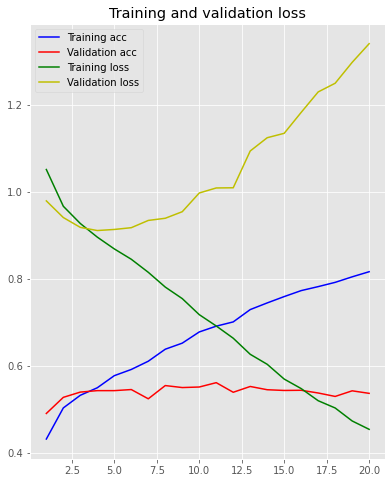

In [25]:
plot_history(history)